# Introduction

In this lab, we will learn how to use LassoLarsIC estimator to select the best Lasso model using AIC and BIC criteria. We will use the diabetes dataset from scikit-learn.

# Load the Data

We will load the diabetes dataset from scikit-learn using the load_diabetes method.

In [8]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In addition, we add some random features to the original data to better illustrate the feature selection performed by the Lasso model.

In [9]:
import numpy as np
import pandas as pd

rng = np.random.RandomState(42)
n_random_features = 14
X_random = pd.DataFrame(
    rng.randn(X.shape[0], n_random_features),
    columns=[f"random_{i:02d}" for i in range(n_random_features)],
)
X = pd.concat([X, X_random], axis=1)
# Show only a subset of the columns
X[X.columns[::3]].head()

,age,bp,s3,s6,random_02,random_05,random_08,random_11
0,0.038076,0.021872,-0.043401,-0.017646,0.647689,-0.234137,-0.469474,-0.465730
1,-0.001882,-0.026328,0.074412,-0.092204,-1.012831,-1.412304,0.067528,0.110923
2,0.085299,-0.005670,-0.032356,-0.025930,-0.601707,-1.057711,0.208864,0.196861
3,-0.089063,-0.036656,-0.036038,-0.009362,-1.478522,1.057122,0.324084,0.611676
4,0.005383,0.021872,0.008142,-0.046641,0.331263,-0.185659,0.812526,1.003533


# Selecting Lasso via an information criterion

**LassoLarsIC** provides a Lasso estimator that uses the Akaike information criterion (AIC) or the Bayes information criterion (BIC) to select the optimal value of the regularization parameter alpha.

Before fitting the model, we will standardize the data with a **StandardScaler**. In addition, we will measure the time to fit and tune the hyperparameter alpha in order to compare with the cross-validation strategy.

We will first fit a Lasso model with the AIC criterion.

In [10]:
import time

from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

start_time = time.time()
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(X, y)
fit_time = time.time() - start_time

We store the AIC metric for each value of alpha used during **fit**.

Now, we perform the same analysis using the BIC criterion.

In [11]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

In [12]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

We can check which value of alpha leads to the minimum AIC and BIC.



In [13]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
45.160030,5244.764779,5244.764779
42.300343,5208.250639,5212.341949
21.542052,4928.018900,4936.201520
15.034077,4869.678359,4881.952289
6.189631,4815.437362,4831.802601
5.329616,4810.423641,4830.880191
4.306012,4803.573491,4828.121351
4.124225,4804.126502,4832.765671
3.820705,4803.621645,4836.352124


Finally, we can plot the AIC and BIC values for the different alpha values. The vertical lines in the plot correspond to the alpha chosen for each criterion. The selected alpha corresponds to the minimum of the AIC or BIC criterion.

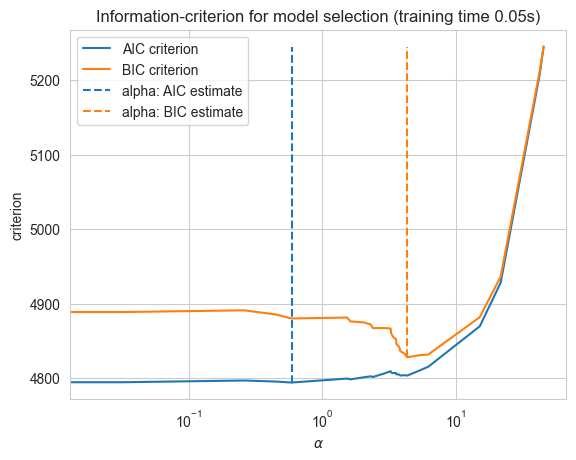

In [14]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)

Model selection with an information-criterion is very fast. It relies on computing the criterion on the in-sample set provided to **fit**. Both criteria estimate the model generalization error based on the training set error and penalize this overly optimistic error. However, this penalty relies on a proper estimation of the degrees of freedom and the noise variance. Both are derived for large samples (asymptotic results) and assume the model is correct, i.e. that the data are actually generated by this model.

These models also tend to break when the problem is badly conditioned (more features than samples). It is then required to provide an estimate of the noise variance.

# Selecting Lasso via cross-validation

The Lasso estimator can be implemented with different solvers: coordinate descent and least angle regression. They differ with regards to their execution speed and sources of numerical errors.

In scikit-learn, two different estimators are available with integrated cross-validation: **LassoCV** and **LassoLarsCV** that respectively solve the problem with coordinate descent and least angle regression.

In the remainder of this section, we will present both approaches. For both algorithms, we will use a 20-fold cross-validation strategy.

# Lasso via coordinate descent

Let’s start by making the hyperparameter tuning using **LassoCV**.

In [15]:
from sklearn.linear_model import LassoCV

start_time = time.time()
model = make_pipeline(StandardScaler(), LassoCV(cv=20)).fit(X, y)
fit_time = time.time() - start_time

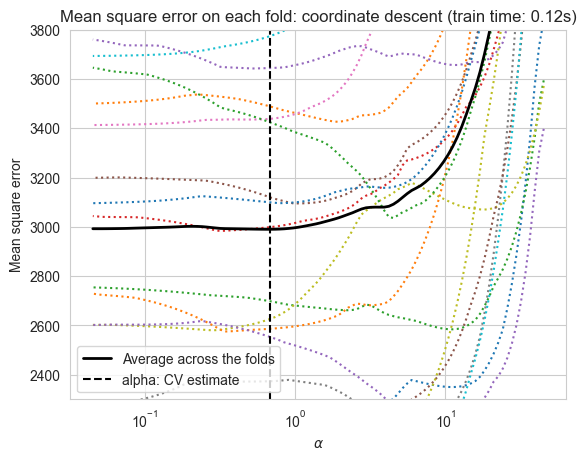

In [16]:
import matplotlib.pyplot as plt

ymin, ymax = 2300, 3800
lasso = model[-1]
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent (train time: {fit_time:.2f}s)"
)

# Lasso via least angle regression

Let’s start by making the hyperparameter tuning using **LassoLarsCV**.

In [17]:
from sklearn.linear_model import LassoLarsCV

start_time = time.time()
model = make_pipeline(StandardScaler(), LassoLarsCV(cv=20)).fit(X, y)
fit_time = time.time() - start_time

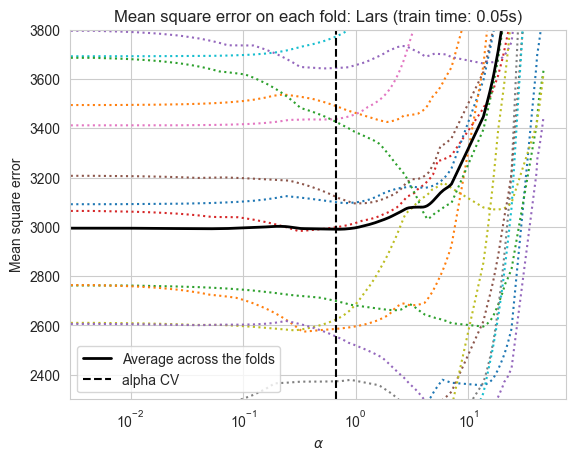

In [18]:
lasso = model[-1]
plt.semilogx(lasso.cv_alphas_, lasso.mse_path_, ":")
plt.semilogx(
    lasso.cv_alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha CV")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(f"Mean square error on each fold: Lars (train time: {fit_time:.2f}s)")

Both algorithms give roughly the same results.

Lars computes a solution path only for each kink in the path. As a result, it is very efficient when there are only of few kinks, which is the case if there are few features or samples. Also, it is able to compute the full path without setting any hyperparameter. On the opposite, coordinate descent computes the path points on a pre-specified grid (here we use the default). Thus it is more efficient if the number of grid points is smaller than the number of kinks in the path. Such a strategy can be interesting if the number of features is really large and there are enough samples to be selected in each of the cross-validation fold. In terms of numerical errors, for heavily correlated variables, Lars will accumulate more errors, while the coordinate descent algorithm will only sample the path on a grid.

Note how the optimal value of alpha varies for each fold. This illustrates why nested-cross validation is a good strategy when trying to evaluate the performance of a method for which a parameter is chosen by cross-validation: this choice of parameter may not be optimal for a final evaluation on unseen test set only.

# Conclusion

In this tutorial, we presented two approaches for selecting the best hyperparameter alpha: one strategy finds the optimal value of alpha by only using the training set and some information criterion, and another strategy is based on cross-validation.

In this example, both approaches are working similarly. The in-sample hyperparameter selection even shows its efficacy in terms of computational performance. However, it can only be used when the number of samples is large enough compared to the number of features.

That’s why hyperparameter optimization via cross-validation is a safe strategy: it works in different settings.